In [1]:
import pickle
import torch 
import math
import control as ct
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from random import randint, uniform
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.optim as optim
from torch.utils.data import random_split
from numpy import linalg as LA
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import Plotter

print(torch.cuda.is_available())
!nvidia-smi
device = torch.device("cuda:0")

True
Wed Feb 19 11:27:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:06:00.0  On |                  N/A |
| 30%   57C    P0            118W /  350W |    1495MiB /  24576MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [2]:
def jPerturb(rvec, num, MU_EARTH):
    """
    Computes the J2_EARTH-J6_EARTH zonal gravitational perturbation
    accelerations.

    :param rvec: Cartesian Position vector in kilometers [x;y;z].
    :param num: Corresponds to which J components to use,
                must be an integer between 2 and 6.
                (note: Additive- 2 corresponds to J2_EARTH while 3 will
                correspond to J2_EARTH + J3_EARTH)
    :param planet: planet variable, can be
                 CELESTIAL_MERCURY
                 CELESTIAL_VENUS
                 CELESTIAL_EARTH
                 CELESTIAL_MOON
                 CELESTIAL_MARS
                 CELESTIAL_JUPITER
                 CELESTIAL_URANUS
                 CELESTIAL_NEPTUNE
    :return: ajtot, The total acceleration vector due to the J
                    perturbations in km/sec^2 [accelx;accely;accelz]
    """

    ajtot = np.zeros(3)

    # default #
    mu = MU_EARTH
    req = 6378.1366
    J2 = 1082.616e-6
    J3 = -2.53881e-6
    J4 = -1.65597e-6
    J5 = -0.15e-6
    J6 = 0.57e-6


    # Calculate the J2 perturbations
    x = rvec[0]
    y = rvec[1]
    z = rvec[2]
    r = LA.norm(rvec)

    # Error Checking #
    if num < 2 or num > 6:
        raise ValueError("ERROR: jPerturb() received num = {}.The value of num should be 2 <= num <= 6.".format(str(num)))

    # Calculating the total acceleration based on user input #
    ajtot = torch.tensor([(1.0 - 5.0 * math.pow(z / r, 2.0)) * (x / r),
                        (1.0 - 5.0 * math.pow(z / r, 2.0)) * (y / r),
                        (3.0 - 5.0 * math.pow(z / r, 2.0)) * (z / r)])
    ajtot = (-3.0 / 2.0 * J2 * (mu / math.pow(r, 2.0)) * math.pow(req / r, 2.0)) * ajtot
    return ajtot

def solarRad(A, m, sunvec, pos):
    """
    Computes the inertial solar radiation force vectors
    based on cross-sectional Area and mass of the spacecraft
    and the position vector of the planet to the sun.

    .. note::

        It is assumed that the solar radiation pressure decreases quadratically with distance from sun (in AU)

    Solar Radiation Equations obtained from
    Earth Space and Planets Journal Vol. 51, 1999 pp. 979-986

    :param A: Cross-sectional area of the spacecraft that is facing the sun in m^2.
    :param m: The mass of the spacecraft in kg.
    :param sunvec: Position vector to the Sun in units of AU. Earth has a distance of 1 AU.
    :return:   arvec, The inertial acceleration vector due to the effects of Solar Radiation pressure in km/sec^2.  The vector
               components of the output are the same as the vector
               components of the sunvec input vector.
    """
    # Solar Radiation Flux #
    flux = 1372.5398

    # Speed of light #
    c = 299792458.

    # Radiation pressure coefficient #
    Cr = 1.3

    # Magnitude of position vector #
    sundist = LA.norm(sunvec)

    # Computing the acceleration vector #
    arvec = ((-Cr * A * flux) / (m * c * math.pow(sundist, 3)) / 1000.) * sunvec

    if pos[0] > 0 and pos[1] > -6378 and pos[1] < 6378:
        arvec = torch.zeros(3,1)

    return arvec

def TBPdyn(t,x,mu,perturb):
    r = torch.sqrt(x[0,0]**2 + x[1,0]**2) # magnitude of position vector
    ax = -mu*x[0,0]/r**3 # acceleration in x-dir based on two-body problem
    ay = -mu*x[1,0]/r**3 # acceleration in y-dir based on two-body problem   

    perturb = 1
    if perturb:
        pos = torch.tensor([[x[0,0]], [x[1,0]], [0]]) 
        j2_acc = jPerturb(pos, 2, mu)
        srp_acc = solarRad(5,1000, torch.tensor([[-1],[0],[0]]),pos)
        ax_total = ax + j2_acc[0] + srp_acc[0]
        ay_total = ay + j2_acc[1] + srp_acc[1]
    else:
        ax_total = ax
        ay_total = ay

    fdyn = torch.tensor([[x[2]], [x[3]], [ax_total], [ay_total]])
    return fdyn

def rk4(func, tk, yk, mu, perturb, dt, *args):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, yk, mu, perturb, *args)
    f2 = func(tk + dt / 2, yk + (f1 * (dt / 2)), mu, perturb, *args)
    f3 = func(tk + dt / 2, yk + (f2 * (dt / 2)), mu, perturb, *args)
    f4 = func(tk + dt, yk + (f3 * dt), mu, perturb, *args)

    # return an average of the derivative over tk, tk + dt
    ykp1 = yk + (dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)
    return ykp1

In [3]:
# loading training data and stacking into 3D array for batch training
data_x = torch.load("X_Data_perturb.pt", weights_only=False)
data_x = torch.FloatTensor(np.stack((data_x[0:200])))
data_y = torch.load("Y_Data_perturb.pt", weights_only=False)
data_y = torch.FloatTensor(np.stack((data_y[0:200])))
data_y2 = torch.load("Y2_Data_perturb.pt", weights_only=False)
data_y2 = torch.FloatTensor(np.stack((data_y2[0:200])))

# loading parametric variables
with open('twobody_data_variables_perturb.pkl', 'rb') as f: # remove 3D for 3D array
    dp,dt,nx,m,predict_time,e = pickle.load(f)
    
# loading the training data for batch training
loader = DataLoader(list(zip(data_x, data_y, data_y2)), shuffle=True, batch_size=200)

# ***Building the Network***

In [4]:
# Hyperparameters
input_size = nx 
lifted_space = 6
hidden_size = 45
learning_rate = 0.00001
P = torch.cat((torch.eye(nx),torch.zeros(nx,lifted_space)),1).to(device)

class Encoder(nn.Module):
    def __init__(self, input_size, lifted_space):
        super(Encoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, lifted_space)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
          encoded = self.encoder(x)
          return encoded         

modelen = Encoder(input_size, lifted_space).to(device)
criterion = torch.nn.MSELoss().to(device) # mean squared loss 
optimizer = optim.Adam(list(modelen.parameters()), lr=learning_rate, weight_decay=1e-5)


# ***Training***

In [5]:
num_epochs = 12000
Loss = []
Loss_prev = 1e38
iterations = 10

for iter in range(iterations): 
    i = 0
    j = 0

    for epoch in range(num_epochs):
        for part_x, part_y, part_y2 in loader:
  
            # stacking the training dataset into a 2D array
            train_x = torch.tensor(np.hstack(part_x)).float().to(device)
            train_y = torch.tensor(np.hstack(part_y)).float().to(device)
            train_y2 = torch.tensor(np.hstack(part_y2)).float().to(device)
            
            # encoding the states and adding the original states to the encoded x data
            phi_k = torch.transpose(modelen(torch.transpose(train_x,0,1)),0,1)
            phi_k = torch.cat((train_x,phi_k),0)                

            # encoding the states and adding the original states to the encoded y data
            phi_kp1 = torch.transpose(modelen(torch.transpose(train_y,0,1)),0,1) 
            phi_kp1 = torch.cat((train_y,phi_kp1),0) 
            
            #~~~~~~~~~~~~~~~~~~~~~ EDMD ~~~~~~~~~~~~~~~~~~~~~~#
            K = torch.matmul(phi_kp1,torch.pinverse(phi_k))
            
            #~~~~~~~~~~~~~~~~~ Multiple Time Step Predicition Loss ~~~~~~~~~~~~~~~~~#
            for l in range(predict_time):
                next_phi = torch.matmul(K,phi_k) 
                next_state = torch.matmul(P,next_phi)
                next_state_encoded = torch.transpose(modelen(torch.transpose(next_state,0,1)),0,1) # stacking original states on 
                phi_k = torch.cat((next_state,next_state_encoded),0)

            loss_x = next_state
            loss_y = train_y2
            loss_1 = criterion(loss_x, loss_y) # prediction loss

            #~~~~~~~~~~~~~~~ One Time Step Prediction loss ~~~~~~~~~~~~~~~~~~~~~~#
            phi_hat_p1 = torch.matmul(K,phi_k)
            x_p1 = torch.matmul(P,phi_hat_p1)

            loss_2 = criterion(x_p1, train_y) # reconstruction loss

            # loss function lambdas
            loss_1_lambda = 0.8
            loss_2_lambda = 100
            loss_2_lambda = 1
            l1_lambda = 0.04
            l2_lambda = 0.01

            l1_regularisation = sum(p.norm().sum()
                  for p in modelen.parameters())
            loss_L1 = l1_lambda * l1_regularisation

            l2_regularisation = sum(p.pow(2.0).sum()
                  for p in modelen.parameters())
            loss_L2 = l2_lambda * l2_regularisation

            loss = loss_1_lambda*loss_1 + loss_2_lambda*loss_2 + loss_L1 + loss_L2 
            
            # Backward and optimize
            optimizer.zero_grad() # find the gradients.
            loss.backward(retain_graph=True) # backprop
            optimizer.step() # updates the weights for the each parameter.

            # storing the K value and model of the best model trained so far
            if loss.item() < Loss_prev or (iter == 0 and epoch == 0):
                best_model = modelen
                torch.save(modelen, '2BPbest-model-perturb.pt')
                K_best = K
                Loss_prev = loss.item()
            modelen = best_model

        # logging of losses
        if (i+1) % 100 == 0:
            print (f'Iteration: [{iter+1}/{iterations}],   Epoch: [{epoch+1}/{num_epochs}],  Loss: {loss.item():.15f},   Loss 1: {loss_1_lambda*loss_1},   Loss 2: {loss_2_lambda*loss_2},   L1 Loss: {loss_L1}, L2 Loss: {loss_L2}')
        i = i+1
        Loss.append(loss.item())

    # storing the best K to a data file
    with open('2BPobjs-perturb.pkl', 'wb') as f:
        pickle.dump(K_best, f)

Iteration: [1/10],   Epoch: [100/12000],  Loss: 2.009966135025024,   Loss 1: 0.09665089100599289,   Loss 2: 0.00019655856885947287,   L1 Loss: 0.7935981750488281, L2 Loss: 1.1195204257965088
Iteration: [1/10],   Epoch: [200/12000],  Loss: 1.998449206352234,   Loss 1: 0.09569443017244339,   Loss 2: 0.00019405074999667704,   L1 Loss: 0.7909252643585205, L2 Loss: 1.111635446548462
Iteration: [1/10],   Epoch: [300/12000],  Loss: 1.986633062362671,   Loss 1: 0.09476318955421448,   Loss 2: 0.00019188993610441685,   L1 Loss: 0.7881628274917603, L2 Loss: 1.1035151481628418
Iteration: [1/10],   Epoch: [400/12000],  Loss: 1.975104570388794,   Loss 1: 0.09428630024194717,   Loss 2: 0.00019084771338384598,   L1 Loss: 0.785351037979126, L2 Loss: 1.0952763557434082
Iteration: [1/10],   Epoch: [500/12000],  Loss: 1.963371753692627,   Loss 1: 0.09373032301664352,   Loss 2: 0.00018951504898723215,   L1 Loss: 0.7824990153312683, L2 Loss: 1.0869529247283936
Iteration: [1/10],   Epoch: [600/12000],  Loss:

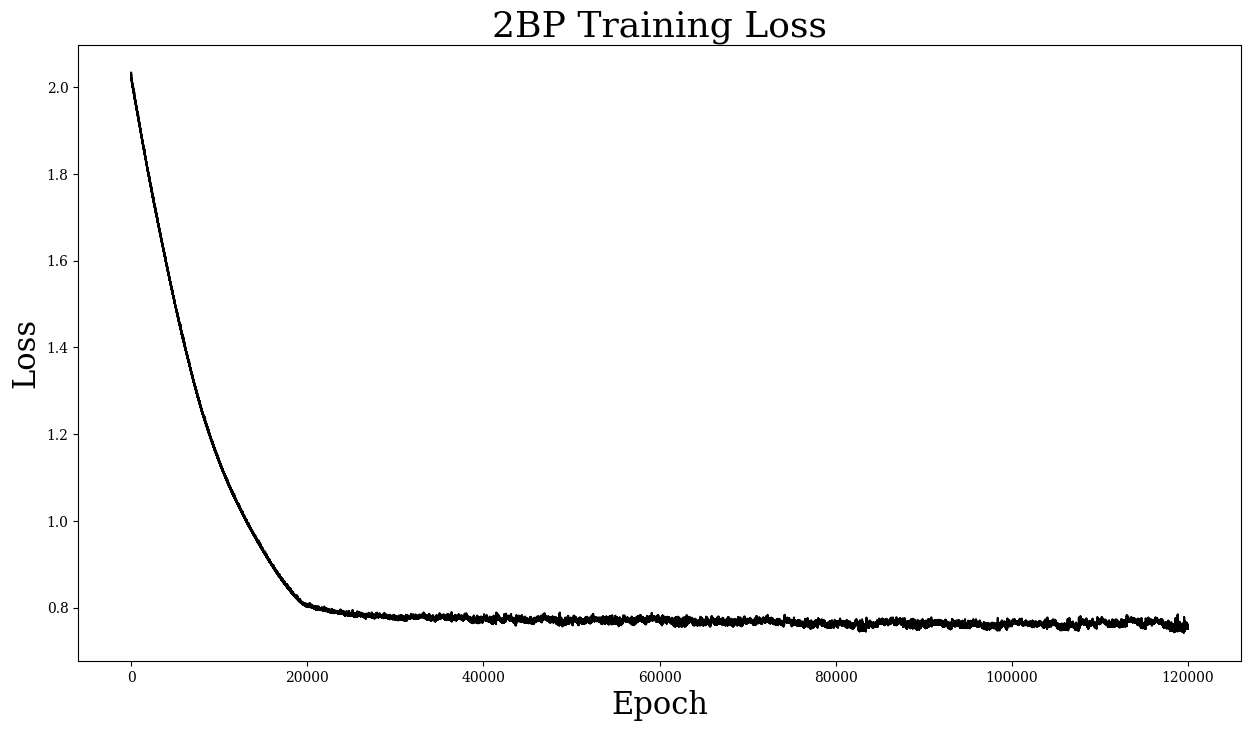

In [6]:
# plotting training loss
mpl.rc('font',family='Serif')
fig, ax = plt.subplots(figsize = (15, 8))
lns = ax.plot(Loss, color='black', label = 'RLDK model')
ax.set_xlabel("Epoch", fontsize = 22)
ax.set_ylabel('Loss', fontsize = 22)
ax.set_title("2BP Training Loss", fontsize=26)
# ax.set_ylim([0.3,1.5])
plt.show()

# ***Plotting States, Errors, Metrics***

In [5]:
# ~~~~~~~~~~~~~~ Loading trained model ~~~~~~~~~~~~~~ #
model = torch.load('2BPbest-model-perturb.pt',weights_only=False)
with open('2BPobjs-perturb.pkl', 'rb') as f: 
    K = pickle.load(f)

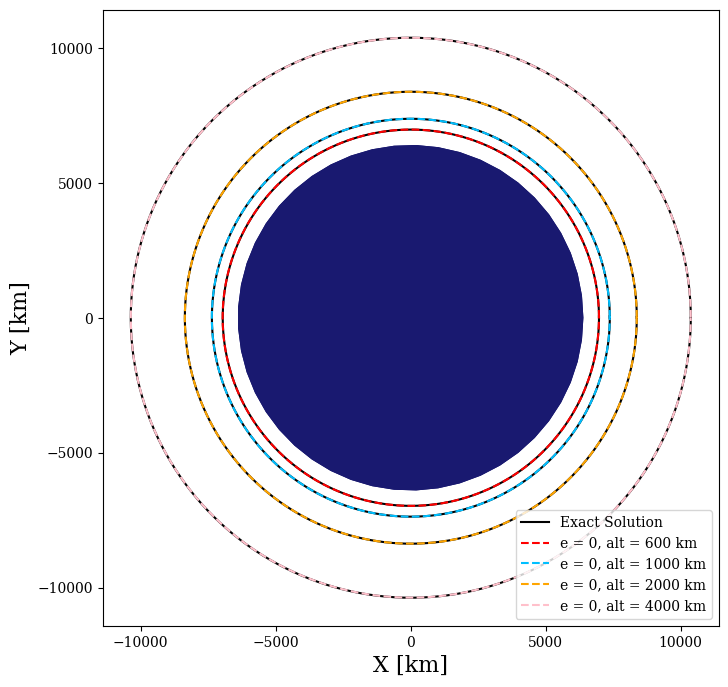

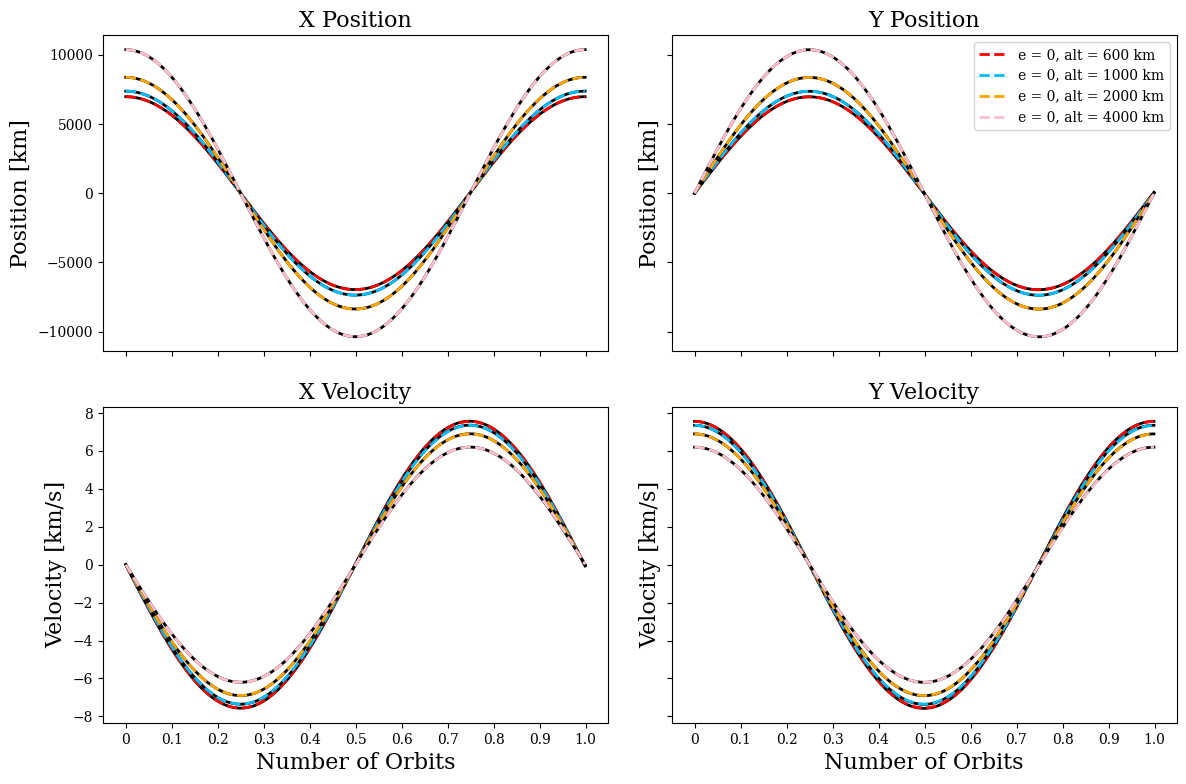

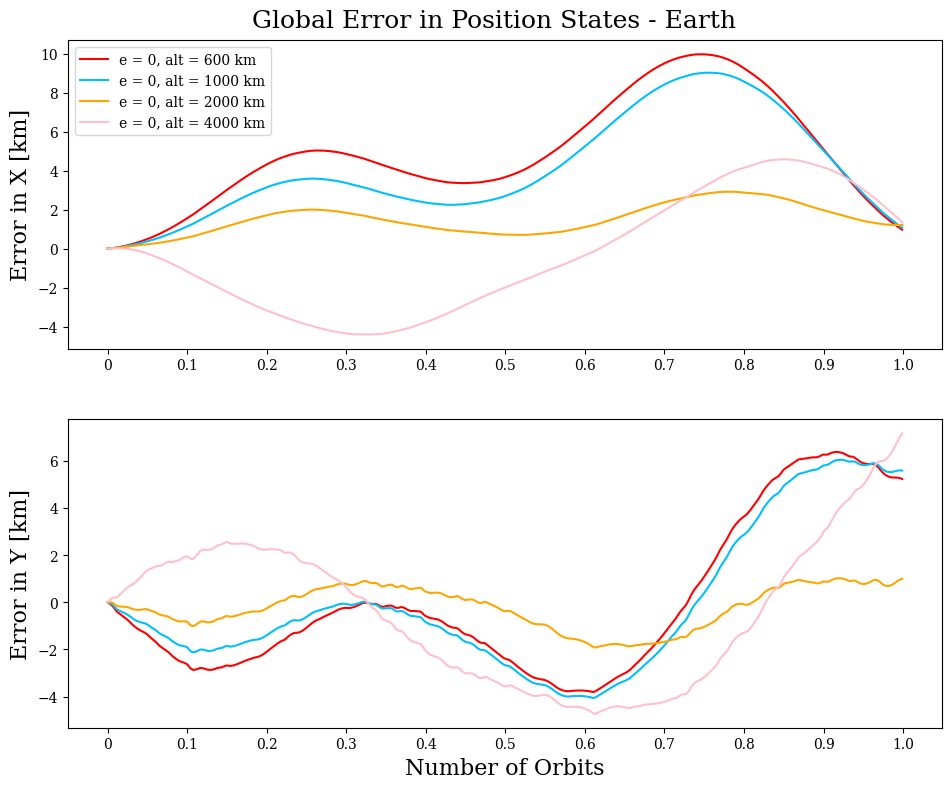

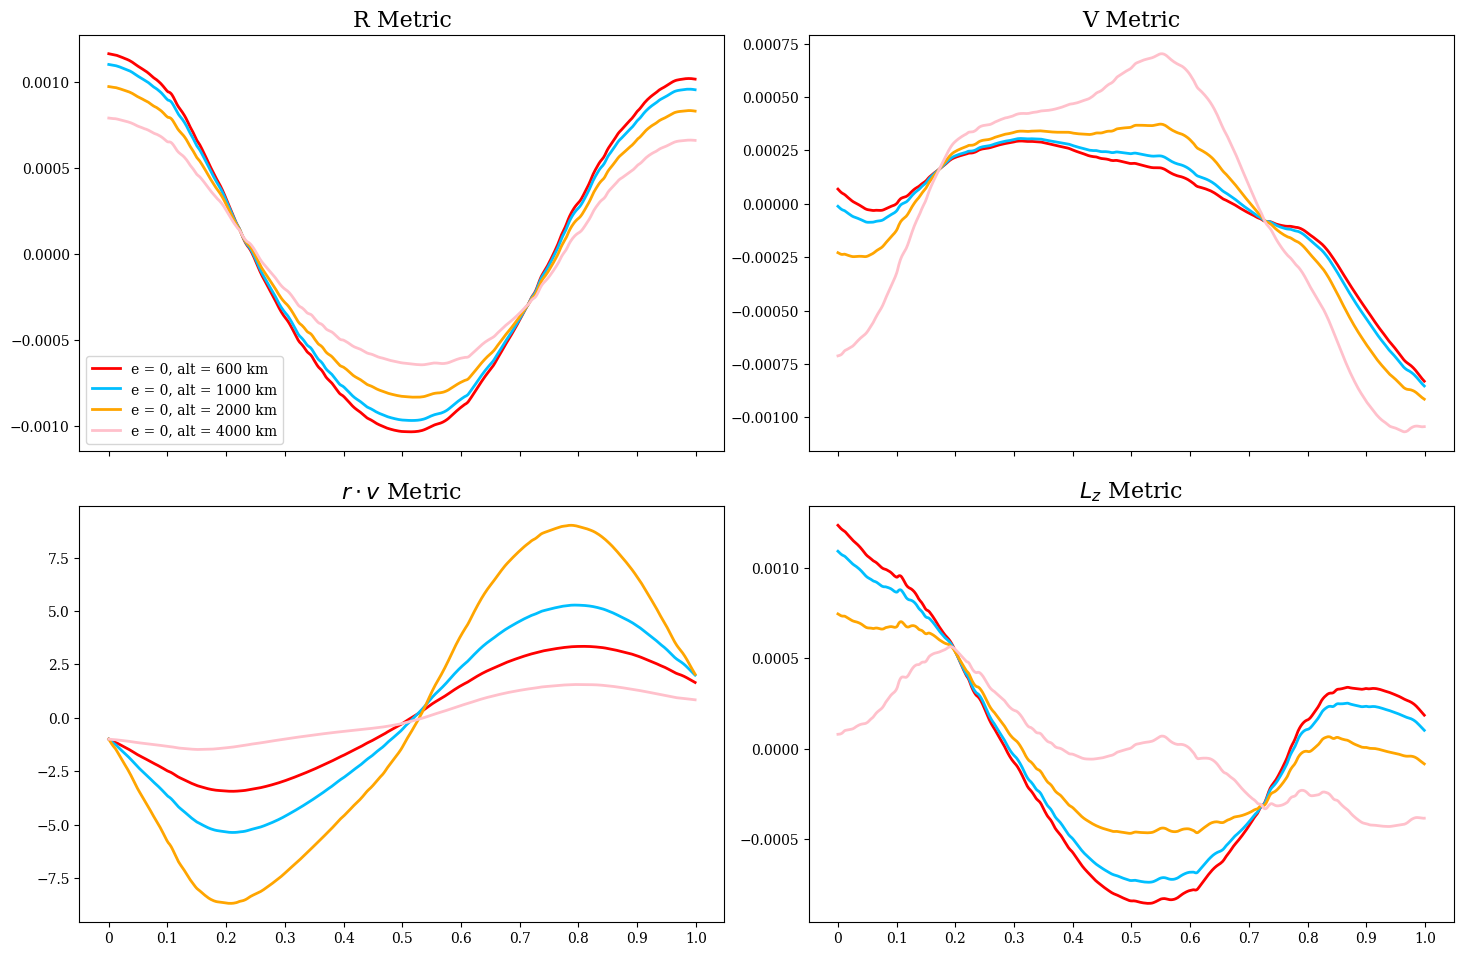

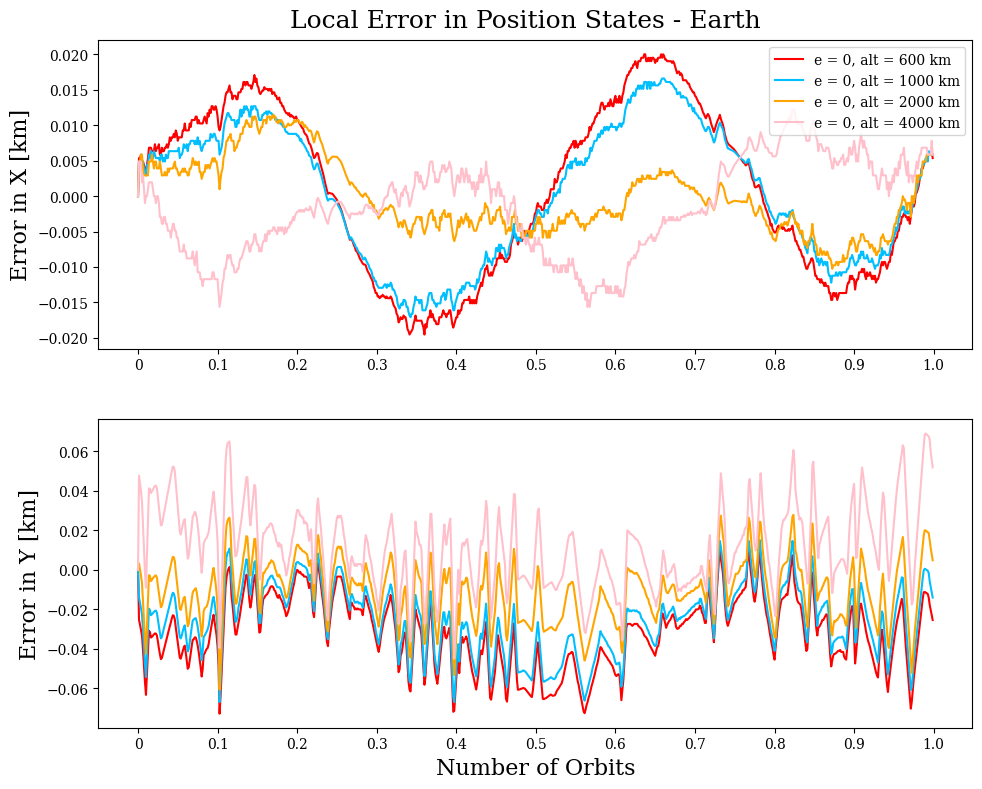

In [6]:
# Two Body Problem parameters
G = 6.6742e-20 # Gravitational constant [m^3*kg^-1*s^-2]
r_Earth = 6378.14  # Average radius of Earth [km]
m1 = 5.974e24 # mass of Earth [kg]
m2 = 1000 # mass of satellite [kg]
mu_Earth = G*(m1 + m2) # gravitational parameter [km^3*s^-2]
alts = [600, 1000, 2000, 4000]
ecc = [0, 0, 0, 0]
num_traj = len(alts)
num_orbits = 1
dp = num_orbits*800
perturb = 1

globalPredArray = np.empty(num_traj, dtype=object)
localPredArray = np.empty(num_traj, dtype=object)
exact = np.empty(num_traj, dtype=object)

# Orbital Dynamics 
for j in range(len(alts)):
    rp = r_Earth + alts[j] # radius of Perigee [km]
    ra = (rp + e*rp)/(1-e)
    a = (rp + ra)/2 # Semi-Major axis [km]
    period = int(2*torch.pi*(a**3/mu_Earth)**0.5) # Period of Orbit

    # initial condition (start at periapsis)
    x = rp
    y = 0
    x_dot = 0
    y_dot = (mu_Earth*((2/rp) - (1/a)))**0.5

    x_0 = torch.tensor([[x], [y], [x_dot], [y_dot]])
    time = np.linspace(0, num_orbits*int(period), dp)
    dt = num_orbits*int(period)/dp

    # ~~~~~~ Creating array to store system state at time k ~~~~~~~ #
    globalPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of global loss
    localPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of local loss
    NL_sol = torch.empty([nx,0]) # separate trajectory for the nonlinear system
    i = 0

    # ~~~~~~ Creating tensors to store system states ~~~~~~~ #
    xG = x_0.to(device)
    xL = x_0.to(device)
    xk = x_0

# ~~~~~~ System Evolution ~~~~~~~ #
    for t in time:

        # ~~~~~~~~ Saving Current State in Array ~~~~~~~~ #
        globalPred = torch.hstack((globalPred, xG)) # saving states
        localPred = torch.hstack((localPred, xL)) # saving states

        # ~~~~~~~~~~ Lifting of States ~~~~~~~~~~ #
        globalEncoded = model(torch.transpose(xG,0,1))
        localEncoded = model(torch.transpose(xk,0,1).to(device))
        phihatGlobal = torch.cat((xG,torch.transpose(globalEncoded,0,1)),0)
        phihatLocal = torch.cat((xk.to(device),torch.transpose(localEncoded,0,1)),0)

        # ~~~~~~~~~ Straight Koopman Prediction ~~~~~~~~~ #
        phihatGlobal_p1 = torch.matmul(K, phihatGlobal)
        phihatLocal_p1 = torch.matmul(K, phihatLocal)

        # ~~~~~~~~~~ Extracting States ~~~~~~~~~~ #
        xG = torch.matmul(P,phihatGlobal_p1) # extracting the next state
        xL = torch.matmul(P,phihatLocal_p1) # extracting the next state

        # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
        NL_sol = np.hstack((NL_sol, xk))
        xk = rk4(TBPdyn, t, xk, mu_Earth, perturb, dt) # RK4 approximation of solution
        i = i+1

    globalPredArray[j] = globalPred
    localPredArray[j] = localPred
    exact[j] = NL_sol

# ~~~~~~~~~~~~~~~~~~~~ Plotting the orbits ~~~~~~~~~~~~~~~~~~~~~~#

Earth_plot = Plotter.Plotter(exact, globalPredArray, r_Earth, alts, ecc, num_orbits, 'Earth', 0, 'perturb')
Earth_plot.perifocalPlot()

# ~~~~~~~~~~~~~~~~~~~ Plotting the States ~~~~~~~~~~~~~~~~~~~~~ #

Earth_plot.statePlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Global Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Earth_plot.errorPlot('Global')

Earth_plot.metricPlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Local Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
Earth_plot = Plotter.Plotter(exact, localPredArray, r_Earth, alts, ecc, num_orbits, 'Earth', 0, 'perturb')
Earth_plot.errorPlot('Local')